# College Basketball Market Efficiency

**Intro**  
To rip off an econ quote, there are very few bettors that shouldn’t behave as if markets are totally efficient. What does this mean? This means for the vast majority of bettors, the markets are too efficient for them to beat consistently, they should withdraw whatever paltry amount they still have in their account, and spend it all on something nice for the wife.

The rest of us might be wondering: how efficient are these markets? Do these efficiency values change over time? Over the past month or so, I’ve heard multiple people say how the college basketball market is becoming more efficient. I happen to know of a low quality data source with college basketball lines, so I figured I’d take a peek.

**Data**  
The data in question comes from [Sportsbook Reviews Online](https://www.sportsbookreviewsonline.com/scoresoddsarchives/ncaabasketball/ncaabasketballoddsarchives.htm). which is the first google result for “historical ncaa basketball lines”. I also just noticed that this page says “There will be no further updates after January 16, 2023” so I guess don’t expect a follow up.

**Measuring Efficiency**  
Market efficiency, specifically in betting markets, is the concept that all available information has been taken into account and the current odds accurately reflect the expected outcome. In order to measure how efficient, we can use the closing pre-game line as a predicted value and the game’s outcome as the true value. 

We’ll look at three different markets:
* Spreads
* Totals
* Moneylines

For spreads and totals, we’ll use a mean squared error to measure the efficiency of the market over a given time span. For moneylines, we’ll use a log-loss metric of implied win probability versus the outcome to measure the efficiency of the market over a given time span.

For spread and totals we also have opening and closing lines. The error metrics for both of these will be plotted on the same chart. Because many bettors have an intuitive sense of the efficiency gains in the market between openers and closers, illustrating this difference can help isolate the amount of efficiency we’re seeing from the line moves.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, mean_squared_error

# Data Collection and Cleaning

In [2]:
# Collect and import the odds and results
years = range(2007,2023)

clean_odds = []

for year in years:

    filename = f'ncaa basketball {str(year)}-{str(year+1)[2:]}.xlsx'
    tmp = pd.read_excel('data/' + filename, engine='openpyxl')
    
    tmp['Open'] = [str(x).split('-')[0] if len(str(x).split('-'))>1 else x for x in tmp['Open']]

    tmp.replace({'Open': {'pk': 0,
                          'PK': 0,
                          'NL': np.nan,
                          'p': 0,
                          '6-109': 6,
                          '25-109': 25,
                          '8-109': 8},
                 'Close': {'pk': 0,
                           'PK': 0,
                           'NL': np.nan},
                 '2H': {'pk': 0,
                        'PK': 0,
                        'NL': np.nan,
                        '.5+03': np.nan},
                 'ML': {'pk': 100,
                        'PK': 100,
                        '-': 100,
                        'NL': np.nan,
                        'N': np.nan,}}, inplace = True)
    
    tmp['Open'] = pd.to_numeric(tmp['Open'])
    tmp['Close'] = pd.to_numeric(tmp['Close'])
    tmp['2H'] = pd.to_numeric(tmp['2H'])
    tmp['ML'] = pd.to_numeric(tmp['ML'])

    cutoff_month = 8
    # Put in the season
    tmp['season'] = year

    # Format the dates
    tmp['day'] = [str(x)[-2:] for x in tmp['Date']]
    tmp['month'] = [str(x)[:1] if len(str(x)) == 3 else str(x)[:2] for x in tmp['Date']]

    tmp['day'] = tmp['day'].astype(int)
    tmp['month'] = tmp['month'].astype(int)

    tmp['year'] = [year if x > cutoff_month else year+1 for x in tmp['month']]

    tmp['datetime'] = pd.to_datetime(tmp[['year', 'month', 'day']])
    tmp.drop(columns=['day', 'month', 'year'], inplace=True)

    # Split it up into visitor data and home data
    tmp['index_plus_1'] = tmp.index + 1
    tmp['odd_even'] = tmp['index_plus_1'] % 2

    df_v = tmp[tmp['odd_even']==1][['season', 'datetime', 'Date', 'VH', 'Team', '1st', '2nd', 'Final', 'Open', 'Close', 'ML', '2H', 'index_plus_1']]
    df_v.rename(columns = { 'VH': 'v_VH',
                            'Team': 'v_Team',
                            '1st': 'v_1st',
                            '2nd': 'v_2nd',
                            'Final': 'v_Final',
                            'Open': 'v_Open',
                            'Close': 'v_Close',
                            'ML': 'v_ML',
                            '2H': 'v_2H'}, inplace =True)

    df_h = tmp[tmp['odd_even']==0][['VH', 'Team', '1st', '2nd', 'Final', 'Open', 'Close', 'ML', '2H']]
    df_h.rename(columns = { 'VH': 'h_VH',
                            'Team': 'h_Team',
                            '1st': 'h_1st',
                            '2nd': 'h_2nd',
                            'Final': 'h_Final',
                            'Open': 'h_Open',
                            'Close': 'h_Close',
                            'ML': 'h_ML',
                            '2H': 'h_2H'}, inplace =True)

    df = df_v.merge(df_h, how = 'left', left_on = 'index_plus_1', right_index = True)

    df.drop(columns = ['index_plus_1'], inplace=True)

    spread_cutoff = 50

    df['v_spread_open'] = [abs(v) * -1 if abs(v) < spread_cutoff else abs(h) for v,h in zip(df['v_Open'],df['h_Open'])]
    df['h_spread_open'] = [abs(h) * -1 if abs(h) < spread_cutoff else abs(v) for v,h in zip(df['v_Open'],df['h_Open'])]
    
    df['v_spread_close'] = [abs(v) * -1 if abs(v) < spread_cutoff else abs(h) for v,h in zip(df['v_Close'],df['h_Close'])]
    df['h_spread_close'] = [abs(h) * -1 if abs(h) < spread_cutoff else abs(v) for v,h in zip(df['v_Close'],df['h_Close'])]

    df['total_open'] = [abs(v) if abs(h) < spread_cutoff else abs(h) for v,h in zip(df['v_Open'],df['h_Open'])]
    df['total_close'] = [abs(v) if abs(h) < spread_cutoff else abs(h) for v,h in zip(df['v_Close'],df['h_Close'])]

    df['v_implied_probability'] = [(100/(x+100))*100 if x > 0 else (-x/(-x+100))*100 for x in df['v_ML']]
    df['h_implied_probability'] = [(100/(x+100))*100 if x > 0 else (-x/(-x+100))*100 for x in df['h_ML']]

    clean_odds.append(df)

clean_odds = pd.concat(clean_odds)
clean_odds.reset_index(inplace=True, drop=True)

In [3]:
# A few data checks

clean_odds = clean_odds[(clean_odds['total_open'] >= 80) & (clean_odds['total_open'] <= 230)]
clean_odds = clean_odds[(clean_odds['total_close'] >= 80) & (clean_odds['total_close'] <= 230)]

clean_odds['v_Final_calc'] = clean_odds['v_1st'] + clean_odds['v_2nd']
clean_odds['h_Final_calc'] = clean_odds['h_1st'] + clean_odds['h_2nd']
clean_odds = clean_odds[(clean_odds['v_Final_calc'] <= clean_odds['v_Final']) & (clean_odds['h_Final_calc'] <= clean_odds['h_Final'])]

clean_odds['total_finish'] = clean_odds['h_Final'] + clean_odds['v_Final']
clean_odds = clean_odds[clean_odds['total_finish']>70]

clean_odds = clean_odds[abs(clean_odds['v_spread_close'])<=50]

# Season level market efficiencies

In [4]:
# Create the final game results
clean_odds['v_spread_finish'] = clean_odds['h_Final'] - clean_odds['v_Final']
clean_odds['total_finish'] = clean_odds['h_Final'] + clean_odds['v_Final']
clean_odds['h_win'] = [1 if x>y else 0 for x,y in zip(clean_odds['h_Final'], clean_odds['v_Final'])]

# Get error metrics by year
spread_mse = []
spread_mse_o = []
total_mse = []
total_mse_o = []
ml_logloss = []

for season in clean_odds['season'].unique():
    tmp = clean_odds[clean_odds['season']==season]
    
    # Spread metrics
    tmp_spread = tmp[['v_spread_finish', 'v_spread_close']].dropna()
    season_spread_mse = mean_squared_error(tmp_spread['v_spread_finish'],
                                           tmp_spread['v_spread_close'])
    spread_mse.append(season_spread_mse)

    tmp_spread_o = tmp[['v_spread_finish', 'v_spread_open']].dropna()
    tmp_spread_o = tmp[tmp['v_Open'].notnull()]
    season_spread_mse_o = mean_squared_error(tmp_spread_o['v_spread_finish'],
                                             tmp_spread_o['v_spread_open'])
    spread_mse_o.append(season_spread_mse_o)

    # Total metrics
    tmp_total = tmp[['total_finish', 'total_close']].dropna()
    season_total_mse = mean_squared_error(tmp_total['total_close'],
                                          tmp_total['total_finish'])
    total_mse.append(season_total_mse)
    
    tmp_total_o = tmp[['total_finish', 'total_open']].dropna()
    season_total_mse_o = mean_squared_error(tmp_total_o['total_open'],
                                            tmp_total_o['total_finish'])
    total_mse_o.append(season_total_mse_o)

    tmp_ml = tmp[['h_implied_probability', 'h_win']].dropna()
    season_ml_logloss = log_loss(tmp_ml['h_win'],
                                 tmp_ml['h_implied_probability']/100)
    ml_logloss.append(season_ml_logloss)


season_evaluation_metrics = pd.DataFrame({'season':clean_odds['season'].unique(),
                                          'spread_mse': spread_mse,
                                          'spread_mse_open': spread_mse_o,
                                          'total_mse': total_mse,
                                          'total_mse_open': total_mse_o,
                                          'ml_logloss': ml_logloss,})

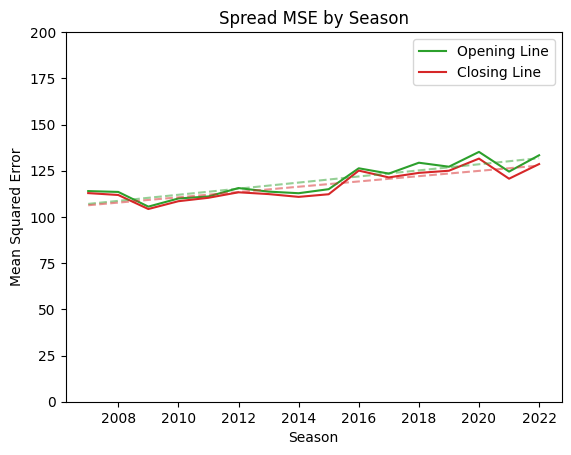

In [5]:
# Spread efficiency by season

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['spread_mse_open'],
         color = 'tab:green',
         label = 'Opening Line')

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['spread_mse'],
         color = 'tab:red',
         label = 'Closing Line')

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['spread_mse_open'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--', color = 'tab:green', alpha = .5)

b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['spread_mse'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--', color = 'tab:red', alpha = .5)


plt.ylim([0,200])
plt.xlabel('Season')
plt.ylabel('Mean Squared Error')
plt.title('Spread MSE by Season')
plt.legend()
plt.show()

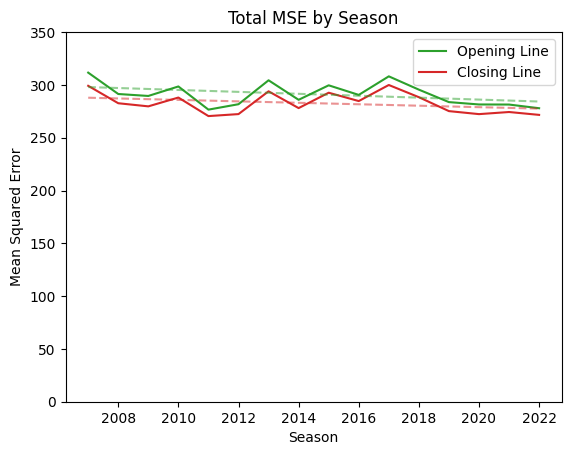

In [6]:
# Total efficiency by season

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['total_mse_open'],
         color = 'tab:green',
         label = 'Opening Line')

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['total_mse'],
         color = 'tab:red',
         label = 'Closing Line')

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['total_mse_open'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--',  color = 'tab:green', alpha = .5)

b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['total_mse'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--', color = 'tab:red', alpha = .5)

plt.ylim([0,350])
plt.xlabel('Season')
plt.ylabel('Mean Squared Error')
plt.title('Total MSE by Season')
plt.legend()
plt.show()

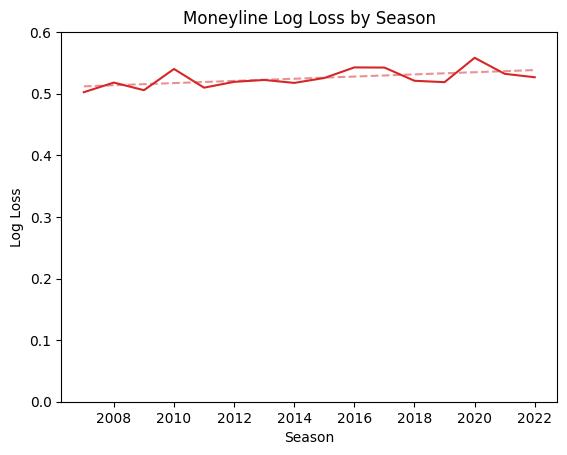

In [7]:
# Moneyline efficiency by season
plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['ml_logloss'],
         color = 'tab:red')

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['ml_logloss'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--', color = 'tab:red', alpha = .5)

plt.ylim([0,.6])
plt.xlabel('Season')
plt.ylabel('Log Loss')
plt.title('Moneyline Log Loss by Season')
plt.show()

## Season level results

Are markets getting more efficient? It does look like the totals market might be getting a touch more efficient over the time span that we’re looking at here. But I don’t think we can say that either the spread or moneyline markets are getting more efficient. It is worth pointing out that the spread market may be more efficient than the totals market, as it has a lower mean squared error.

In looking at the difference between opening and closing lines, it appears that there is a greater efficiency gain in the line moves between opening and close in the spread market than the totals market.

One potential factor that we might want to take into account in the spread market is the variance in scoring from season to season. If the distribution of scores is increasing from season to season then we might expect out mean squared error to also increase for the same “efficiency level”. We can try to normalize for this by dividing the season’s root mean square error value by the standard deviation of score differentials.

In [8]:
spread_sd = []
for season in clean_odds['season'].unique():
    spread_values = abs(clean_odds[clean_odds['season']==season]['v_spread_finish'].dropna().values)
    spread_sd.append(np.std(spread_values))
    
season_evaluation_metrics['spread_sd'] = spread_sd
season_evaluation_metrics['MSE/StDev'] = season_evaluation_metrics['spread_mse'] / season_evaluation_metrics['spread_sd']

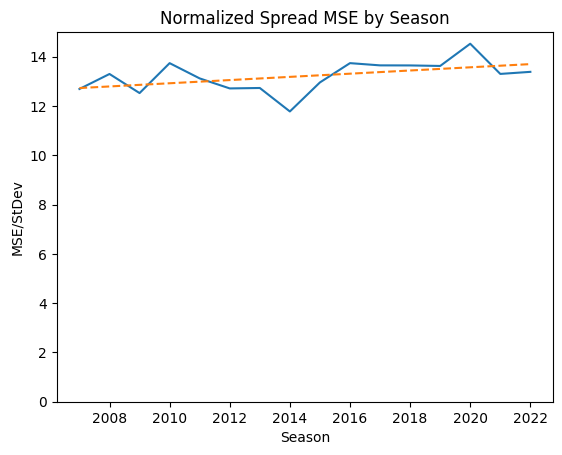

In [9]:
# Normalized spread efficiency by season
plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['MSE/StDev'])

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['MSE/StDev'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--')

plt.ylim([0,15])
plt.xlabel('Season')
plt.ylabel('MSE/StDev')
plt.title('Normalized Spread MSE by Season')
plt.show()

Now that we’ve normalized for the variance in scoring between seasons, it does look like the spread market is getting more efficient with time.

# Intra-season market efficiencies

Now that we’ve the season level efficiencies over time, we might as well take a look at the way theses markets evolve over a season. In the following plots we’ll look at the same three markets, but this time look at the error metrics on a monthly basis throughout the season.

In [10]:
evals = []

for season in clean_odds['season'].unique():

    tmp = clean_odds[clean_odds['season']==season].copy()
    tmp['month'] = [x.month for x in tmp['datetime']]
    tmp = tmp[tmp['month']!=4]

    for month in tmp['month'].unique():
        tmp_m = tmp[tmp['month']==month].copy()

        tmp_spread = tmp_m[['v_spread_finish', 'v_spread_close']].dropna()
        month_spread_mse = mean_squared_error(tmp_spread['v_spread_finish'],
                                               tmp_spread['v_spread_close'])

        tmp_close = tmp_m[['total_finish', 'total_close']].dropna()
        month_total_mse = mean_squared_error(tmp_close['total_close'],
                                              tmp_close['total_finish'])


        tmp_ml = tmp_m[['h_implied_probability', 'h_win']].dropna()
        month_ml_logloss = log_loss(tmp_ml['h_win'],
                                     tmp_ml['h_implied_probability']/100)
        evals.append({'season': season,
                      'month': month,
                      'spread_mse': month_spread_mse,
                      'spread_sd': np.std(abs(tmp_spread['v_spread_finish'])),
                      'total_mse': month_total_mse,
                      'total_sd': np.std(abs(tmp_close['total_finish'])),
                      'ml_logloss': month_ml_logloss,})
evals = pd.DataFrame(evals)

# Add an ordering to the months
month_order = pd.DataFrame({'month': [11, 12,  1,  2,  3],
                            'order': [0,1,2,3,4]})
evals = evals.merge(month_order, how = 'left', on='month')

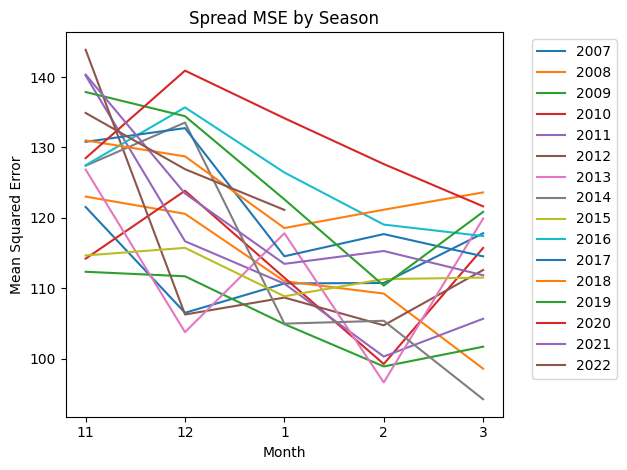

In [11]:
# Spread
for season in evals['season'].unique():
    tmp = evals[(evals['season'] == season)]
    plt.plot(tmp['order'],
         tmp['spread_mse'], label = str(season))
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Mean Squared Error')
plt.title('Spread MSE by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

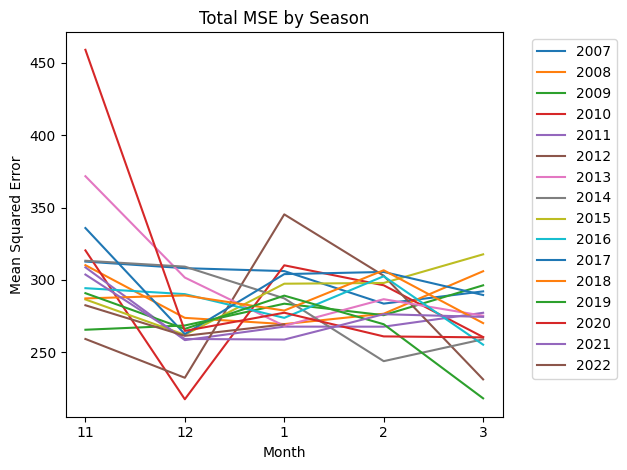

In [12]:
# Total
for season in evals['season'].unique():
    tmp = evals[(evals['season'] == season) & (evals['order'] < 5)]
    plt.plot(tmp['order'],
         tmp['total_mse'], label = str(season))
    #plt.ylim([0,140])
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Mean Squared Error')
plt.title('Total MSE by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

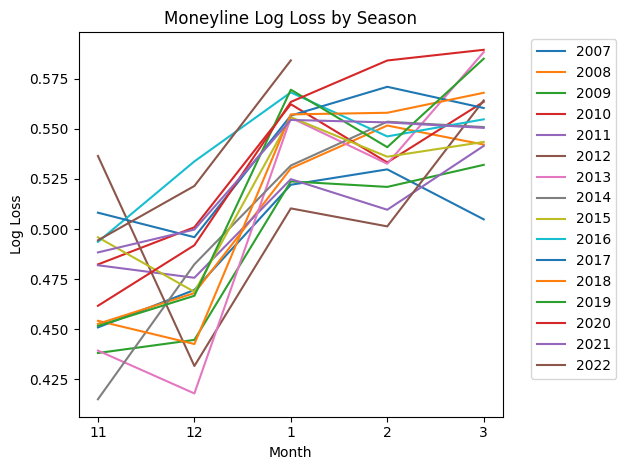

In [13]:
# Moneyline
for season in evals['season'].unique():
    tmp = evals[(evals['season'] == season) & (evals['order'] < 5)]
    plt.plot(tmp['order'],
             tmp['ml_logloss'], label = str(season))
    #plt.ylim([0,140])
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Log Loss')
plt.title('Moneyline Log Loss by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

It looks like both the spread and totals market decrease in their error metric as the season progresses. This aligns with the intuition that the markets get more efficient as more games are played and more data is collected. The moneyline market, however, looks to get less efficient as the season goes on.

# Conclusion

In the plots above, we’ve shown that the college basketball market efficiencies do change over time. At a season-level, it looks like the totals market it getting slightly more efficient while the spread and outright markets are getting slightly less efficient. Throughout the season, we can expect that the spread and total markets get more efficient, while the outrights market might tend towards being slightly less efficient over time. We can also, as expected, expect the closing lines to be more efficient than the opening line.

As someone who has played around with some modeling, I think it will be useful to have these error metrics as sort of a rule of thumb that measures how sharp the market really is. I think compiling these types of numbers across different sports could be useful, and I might just continue putting these out!